# Chapter 9. The `multiprocessing` Module

## Questions You'll Be Able to Answer After This Chapter

- What does the `multiprocessing` module offer?<br>
  `multiprocessing` 모듈은 뭘 제공하는가?

- What's the difference between processes and threads?<br>
  Process와 Thread의 차이점?

- How do I choose the right size for a process pool?<br>
  어떻게 적당한 크기의 Process Pool을 만들 수 있을까?

- How do I use non-persistent queues for work processing?<br>
  영속적이지 않은 Queue들로 작업하기 (아마도 .. Job Queue에 대한 이야기)

- What are the costs and benefits of interprocess communication?<br>
  Interprocess communication의 장단점

- How can I process `numpy` data with many CPUs?<br>
  의) 어떻게 멀티코어로 numpy를 사용하는가?

- Why do I need locking to avoid data loss?<br>
  왜 Data loss를 방지하기 위해 locking이 필요한가?


#### CPython은 default로 multicore를 사용하지 않는다. (python이니까..)


#### n-times speedup with n-cores.
일반적으로 코어를 많이 사용할 수록 성능은 올라간다.

#### Amdahl's Law [Wikipedia](https://en.wikipedia.org/wiki/Amdahl%27s_law)

> 암달의 법칙(Amdahl's law)은 암달의 저주로도 불리며 컴퓨터 시스템의 일부를 개선할 때 전체적으로 얼마만큼의 최대 성능 향상이 있는지 계산하는 데 사용된다. 진 암달의 이름에서 따왔다.

병렬 컴퓨팅에서 멀티 프로세서를 사용할 때 프로그램의 성능향상은 프로그램의 순차적인 부분에 의해 제한된다.
예를 들면, 프로그램의 95%가 병렬화 할 수 있다면 이론적인 최대 성능 향상은 아무리 많은 프로세서를 사용하더라도 최대 20배로 제한된다.


#### Multiprocessing module은 process, thread기반의 병렬 프로세싱을 할 수 있게 해준다.
- single-machine multicore parallelism.


#### 일반적으로 CPU-bound 문제를 병렬화 하는데 사용함.
- I/O-bound 문제에도 사용하기도 함.. (Chapter 8에서 본 `gevent`와 `tornado`, `asyncIO` 등..)
- 기존 작업을 Parallelize하기 위해선 생각할 것이 많다.
- debugging이 힘듦.
- 개발속도 저하.


#### Sharing of state in a parallel system
- parallelism에서 봉착하는 대표적인 문제 중 하나
- 큰 오버헤드가 발생할 수 있음. (오히려 역효과)
- Synchronization cost를 줄이는 방법.
- Avoiding shared state will make  your life far easier.


#### Typical Jobs for the Multiprocessing Module
- Parallelize a CPU-bound task with `Process` of `Pool` objects.
- Parallelize an I/O-bound task in a Pool with threads using the (oddly named) `dummy` module.
- Share `pickled` work via a Queue.
- Share state between parallelized workers, including bytes, primitive datatypes, dictionaries, and lists.
- An Overview of the Multiprocessing Module


## An Overview of the Multiprocessing Module

### `multiprocessing`모듈의 메인 컴포넌트들

#### `Process`
- A forked copy of the current process

#### `Pool`
- Wraps the `Process` or `threading`

#### `Queue`
- A FIFO queue allowing multiple producers and consumers.

#### `Pipe`
- A uni- or bidirectionanl communication channel between two processes.

#### `Manager`
- A high-level managed interface to share Python objects between processes.

#### `ctypes`
- Allows sharing of primitive datatypes (e.g., integers, floats, and bytes) between processes after they have forked.


#### 책에 소개된 몇가지 예제들

[몬테카를로 기법](https://en.wikipedia.org/wiki/Monte_Carlo_method)으로 `pi`값을 추정해 보기. (`Pool`, `numpy` 사용)
복잡도에 대해 잘 알려진 문제이고, 쉽게 parallelize될 수 있음.

- thread로 numpy를 사용하여 구현.
- Pool을 사용해서 구현.


## Estimating Pi Using the Monte Carlo Method

### No use `multiprocessing` (named "Series"), Using threads, Using processes


In [1]:
# Estimating pi using a loop in Python

import random

def estimate_npr_points_in_quarter_circle(nbr_samples):
    nbr_trials_in_quarter_unit_circle = 0
    
    for step in xrange(int(nbr_samples)):
        x = random.uniform(0, 1)
        y = random.uniform(0, 1)
        
        is_in_unit_circle = x * x + y * y <= 1.0
        
        nbr_trials_in_quarter_unit_circle += is_in_unit_circle
        
    return nbr_trials_in_quarter_unit_circle

In [3]:
# estimatin pi using a loop

import time
from multiprocessing import Pool

def estimate_pi_using_multiprocessing(fn, parallel_block_count, samples_in_total):

    pool = Pool(processes=parallel_block_count)
    nbr_samples_per_worker = samples_in_total / parallel_block_count

    # each process's trial count
    nbr_trials_per_process = [nbr_samples_per_worker for _ in range(parallel_block_count)]

    t1 = time.time()

    # It takes very long time...
    nbr_in_unit_circles = pool.map(fn, nbr_trials_per_process)

    delta = time.time() - t1
    pi_estimate = sum(nbr_in_unit_circles) * 4 / samples_in_total
    
    return pi_estimate, delta


In [3]:
# 100000000 samples, and 4 parallel blocks

nbr_samples_in_total = 1e8
nbr_parallel_blocks = 4

print "Making %s samples per worker(worker count=%s)" % (
    nbr_samples_in_total / nbr_parallel_blocks, nbr_parallel_blocks)

pi_estimate, delta = estimate_pi_using_multiprocessing(
    fn=estimate_npr_points_in_quarter_circle,
    parallel_block_count=nbr_parallel_blocks,
    samples_in_total=nbr_samples_in_total
)

print "Estimated pi", pi_estimate
print "Delta: ", delta


Making 25000000.0 samples per worker(worker count=4)
Estimated pi 3.14171128
Delta:  15.6767010689


[1, 2, 3, 4, 5, 6, 7, 8, 9]


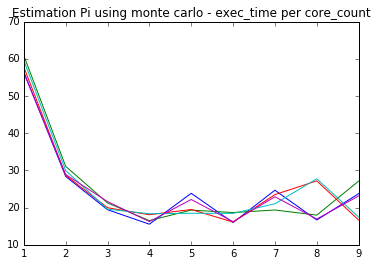

In [4]:
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

trial_count = 5

nbr_samples_in_total = 1e8

process_count = [i for i in range(1, 10)]

print process_count
for _ in range(trial_count):
    exec_times = []
    for process in process_count:
        estimate, delta = estimate_pi_using_multiprocessing(
            fn=estimate_npr_points_in_quarter_circle,
            parallel_block_count=process,
            samples_in_total=nbr_samples_in_total
        )

        exec_times.append(delta)

    plt.plot(process_count, exec_times)
    
plt.title('Estimation Pi using monte carlo - exec_time per core_count')
plt.show()


### GIL Battle

 - The Python GIL Visualized ( http://bit.ly/GIL_visualized )<br>
    1 core로 thread가 2이상일 때, thread들이 서로 GIL을 갖기위해 Race Condition 상황이 발생함.
    

 - Understanding the Python GIL ( http://www.dabeaz.com/GIL/ )<br>
    Threads in Python are great for I/O-bound tasks,<br>
    but they're a poor choice for CPU-bound problems<br>

 - negative effect of thread on CPU-bound problems is<br>
   resonably solved in Python 3.2+<br>
   ( http://docs.python.org/dev/watsnew/3.2.html )<br>

### Hyper-Threading may be Killing your Parallel Performance
 - https://www.pugetsystems.com/labs/hpc/Hyper-Threading-may-be-Killing-your-Parallel-Performance-578/


## Random Numbers in Parallel Systems

  Generating good random number sequences is a hard problem<br>
  use `numpy` random number generator.



In [1]:
import numpy as np

def estimate_nbr_points_in_quarter_circle_using_numpy(nbr_samples):
    
    # set random seed for numpy in each new process
    # else the fork will mean they all share the same state
    
    np.random.seed()
    sample_length = int(nbr_samples)
    xs = np.random.uniform(0, 1, sample_length)
    ys = np.random.uniform(0, 1, sample_length)
    
    estimate_inside_quarter_unit_circle = (xs * xs + ys * ys) <= 1
    
    nbr_trials_in_quarter_unit_circle = np.sum(estimate_inside_quarter_unit_circle)
    
    return nbr_trials_in_quarter_unit_circle

In [4]:
# 100000000 samples, and 4 parallel blocks

nbr_samples_in_total = 1e8
nbr_parallel_blocks = 4

print "Making %s samples per worker(worker count=%s)" % (
    nbr_samples_in_total / nbr_parallel_blocks, nbr_parallel_blocks)

pi_estimate, delta = estimate_pi_using_multiprocessing(
    fn=estimate_nbr_points_in_quarter_circle_using_numpy,
    parallel_block_count=nbr_parallel_blocks,
    samples_in_total=nbr_samples_in_total
)

print "Estimated pi", pi_estimate
print "Delta: ", delta


Making 25000000.0 samples per worker(worker count=4)
Estimated pi 3.14171536
Delta:  0.939512968063


[1, 2, 3, 4, 5, 6, 7, 8, 9]


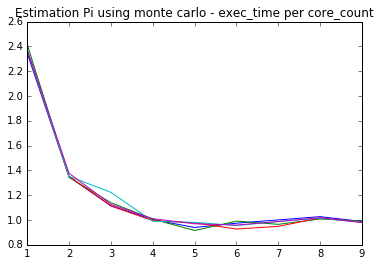

In [4]:
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

trial_count = 5

nbr_samples_in_total = 1e8

process_count = [i for i in range(1, 10)]

print process_count
for _ in range(trial_count):
    exec_times = []
    for process in process_count:
        estimate, delta = estimate_pi_using_multiprocessing(
            fn=estimate_nbr_points_in_quarter_circle_using_numpy,
            parallel_block_count=process,
            samples_in_total=nbr_samples_in_total
        )

        exec_times.append(delta)

    plt.plot(process_count, exec_times)
    
plt.title('Estimation Pi using monte carlo - exec_time per core_count')
plt.show()

## Finding Prime Numbers


In [1]:
# Finding prime numbers using python
import math

def check_prime(n):
    if n % 2 == 0:
        return False
    from_i = 3
    to_i = math.sqrt(n) + 1
    
    for i in xrange(from_i, int(to_i), 2):
        if n % i == 0:
            return False
        
    return True


In [2]:
import time

def estimate_prime_range(non_prime_delta, prime_delta, prime_range):

    for i in prime_range:
        
        t1 = time.time()
        
        is_prime = check_prime(i)
        
        delta = time.time() - t1
        idx = i - 1
        
        if is_prime:
            data_set = prime_delta
        else:
            data_set = non_prime_delta

        if data_set[idx] < 0.0:
            data_set[idx] = delta
        else:
            if delta < data_set[idx]:
                data_set[idx] = delta
            else:
                data_set[idx] = data_set[idx]

    return prime_delta, non_prime_delta


1000000 1000000
[-1. -1. -1. ..., -1. -1. -1.] [-1. -1. -1. ..., -1. -1. -1.]
trial=0
trial=1
trial=2
trial=3
trial=4
trial=5
trial=6
trial=7
trial=8
trial=9
trial=10
trial=11
trial=12
trial=13
trial=14
trial=15
trial=16
trial=17
trial=18
trial=19
77269 77269
912731 912731


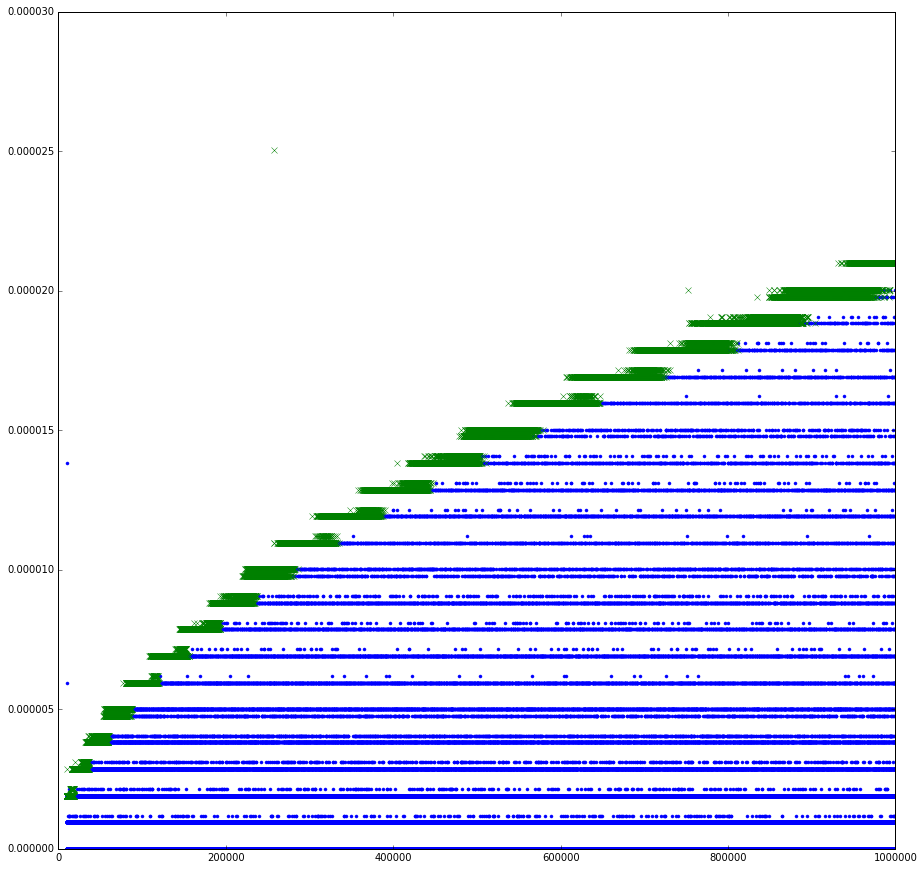

In [3]:
from multiprocessing import Pool

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

proc_count = 4

from_num = 10000
to_num = 1000000

job_ranges = [
    range(
        from_num + (
            (to_num - from_num) / proc_count * proc_idx),

        from_num + (
            (to_num - from_num) / proc_count * (proc_idx + 1))
    ) for proc_idx in range(proc_count)
]

trial_count = 20

non_prime_delta_set = np.zeros(to_num)
non_prime_delta_set.fill(-1)

prime_delta_set = np.zeros(to_num)
prime_delta_set.fill(-1)

print len(non_prime_delta_set), len(prime_delta_set)
print prime_delta_set, non_prime_delta_set

for i in range(trial_count):
    pool = Pool(proc_count)
    for job_range in job_ranges:
        prime_delta_set, non_prime_delta_set = pool.apply(
            estimate_prime_range, args=(
                non_prime_delta_set, prime_delta_set, job_range)
        )
    pool.close()
    pool.join()
    print 'trial=%s' % i

fig = plt.gcf()
fig.set_size_inches(15, 15)

prime_delta_set = [i for i in prime_delta_set if i >= 0]
non_prime_delta_set = [i for i in non_prime_delta_set if i >= 0]

prime_set = [
    i for i in range(from_num, to_num) if check_prime(i)
]

non_prime_set = [
    i for i in range(from_num, to_num) if check_prime(i) is False
]
print len(prime_set), len(prime_delta_set)
print len(non_prime_set), len(non_prime_delta_set)

plt.plot(
    non_prime_set, non_prime_delta_set, '.'
)
plt.plot(
    prime_set, prime_delta_set, 'x'
)

plt.show()
